In [1]:
import os
import glob
import wave
import core as co
import pydub
import librosa
import itertools
import numpy as np
import contextlib
import tensorflow as tf
import sklearn.metrics as metrics

In [2]:
paths = ['BD15C', 'BD15L', 'BD6B', 'BD6A']

In [3]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size / 2)


def extract_features(parent_dir,sub_dirs,file_ext="*.wav",bands = 60, frames = 41, label = 1):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    for l, sub_dir in enumerate(sub_dirs):
        for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
            sound_clip,s = librosa.load(fn)
            for (start,end) in windows(sound_clip,window_size):
                if(len(sound_clip[start:end]) == window_size):
                    signal = sound_clip[start:end]
                    melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                    logspec = librosa.logamplitude(melspec)
                    logspec = logspec.T.flatten()[:, np.newaxis].T
                    log_specgrams.append(logspec)
                    labels.append(l)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels)

In [4]:
parent_dir = '.'

if os.path.exists('features.npy') and os.path.exists('labels.npy'):
    features = np.load('features.npy')
    labels = np.load('labels.npy')
else:
    features,labels = extract_features(parent_dir,paths,frames=41)
    np.save('features.npy', features)
    np.save('labels.npy', labels)

In [16]:
np.save('features.npy', features)
np.save('labels.npy', labels)

In [5]:
labels = co.one_hot_encode(labels)

In [6]:
rnd_indices = np.random.rand(len(labels)) < 0.70

train_x = features[rnd_indices]
train_y = labels[rnd_indices]
test_x = features[~rnd_indices]
test_y = labels[~rnd_indices]

In [7]:
frames = 41
bands = 60

feature_size = bands * frames #60x41
num_labels = 4
num_channels = 2

batch_size = 50
kernel_size = 30
depth = 20
num_hidden = 200

starter_learning_rate = 1e-4
training_iterations = 2000
step = 300
decay = 0.85

In [8]:
X = tf.placeholder(tf.float32, shape=[None, bands, frames, num_channels])
Y = tf.placeholder(tf.float32, shape=[None, num_labels])
phase_train = tf.placeholder(tf.bool, name='phase_train')
global_step = tf.Variable(0, trainable=False)

conv1 = co.conv_layer(X, num_channels, depth, phase_train, 'conv1', kernel_size, kernel_size)
conv2 = co.conv_layer(conv1, depth, depth*2, phase_train, 'conv2', kernel_size, kernel_size)
max_pool_1 = co.max_pool_layer(conv2, name='max_pool_1')
shape = max_pool_1.get_shape().as_list()
max_pool_1_flat = tf.reshape(max_pool_1, [-1, shape[1] * shape[2] * shape[3]])

fc1 = co.fc_layer(max_pool_1_flat, shape[1] * shape[2] * shape[3], num_hidden, phase_train, 'fc1') # fc_layer fc1
y_ = co.fc_layer(tf.nn.relu(fc1), num_hidden, num_labels, phase_train, 'fc2')

In [9]:
learning_rate = tf.train.exponential_decay(starter_learning_rate,global_step,step,decay,staircase=True)

with tf.name_scope('xent'):
    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=y_))
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy, global_step=global_step)
with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
cost_history = np.empty(shape=[1],dtype=float)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())

    for itr in range(training_iterations):    
        offset = (itr * batch_size) % (train_y.shape[0] - batch_size)
        batch_x = train_x[offset:(offset + batch_size), :, :, :]
        batch_y = train_y[offset:(offset + batch_size), :]
        
        _, c, a = session.run([optimizer, cross_entropy, accuracy],feed_dict={X: batch_x, Y : batch_y, phase_train : True})
        cost_history = np.append(cost_history,c)
        if itr % 50 == 0:
            _, tc, ta = session.run([optimizer, cross_entropy, accuracy],feed_dict={X: test_x, Y : test_y, phase_train : False})
            print ('Train cost', c, 'Accuracy', a, 'Test cost', tc, 'Accuracy', ta)

    y_pred = session.run(y_, feed_dict={X: test_x, Y: test_y, phase_train: False})
    print('Test accuracy',round(session.run(accuracy, feed_dict={X: test_x, Y: test_y, phase_train: False}) , 3))
    

('Train cost', 0.86444592, 'Accuracy', 0.34, 'Test cost', 29.475174, 'Accuracy', 0.14864865)
('Train cost', 2.4103284, 'Accuracy', 0.0, 'Test cost', 1.6933149, 'Accuracy', 0.41621622)
('Train cost', 1.7159706, 'Accuracy', 0.0, 'Test cost', 1.1760935, 'Accuracy', 0.41891894)
('Train cost', 1.5948157, 'Accuracy', 0.0, 'Test cost', 0.94248557, 'Accuracy', 0.68378389)
('Train cost', 1.202878, 'Accuracy', 0.53999996, 'Test cost', 0.8128677, 'Accuracy', 0.74324334)
('Train cost', 0.11154973, 'Accuracy', 1.0, 'Test cost', 0.71557128, 'Accuracy', 0.6648649)
('Train cost', 0.41858792, 'Accuracy', 1.0, 'Test cost', 0.59386826, 'Accuracy', 0.79729736)
('Train cost', 0.08499901, 'Accuracy', 1.0, 'Test cost', 0.52589619, 'Accuracy', 0.81621623)
('Train cost', 0.51302284, 'Accuracy', 0.79999995, 'Test cost', 0.51710188, 'Accuracy', 0.79459465)
('Train cost', 0.014545627, 'Accuracy', 1.0, 'Test cost', 0.47399211, 'Accuracy', 0.80810809)
('Train cost', 0.24778003, 'Accuracy', 1.0, 'Test cost', 0.85263

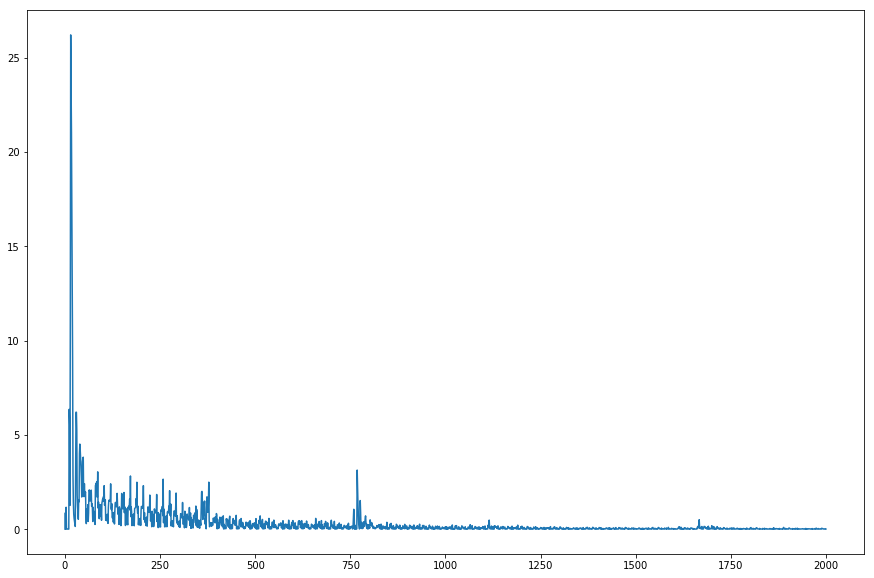

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,10))
plt.plot(cost_history)
# plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

In [12]:
y_test_class = np.argmax(test_y, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)
conf_mat = metrics.confusion_matrix(y_test_class, y_pred_class)

Confusion matrix:
	C0 C1 C2 C3
 C0:	[53  0  2  0]
 C1:	[  0 152   0   2]
 C2:	[ 0  0 76  0]
 C3:	[ 0  4  2 79]


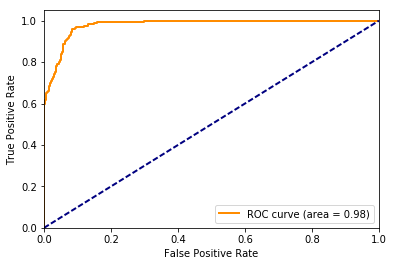

ROC AUC Score:  0.979807654721


In [13]:
print("Confusion matrix:\n\tC0 C1 C2 C3\n C0:\t{}\n C1:\t{}\n C2:\t{}\n C3:\t{}".format(conf_mat[0],conf_mat[1],conf_mat[2],conf_mat[3]))

# Compute ROC curve and ROC area for each class
n_classes = 4
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(test_y[:, i], y_pred[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(test_y.ravel(), y_pred.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

roc_score = metrics.roc_auc_score(test_y, y_pred)

#print "Loss: {} Accuracy: {}%".format(loss_and_metrics[0],loss_and_metrics[1] * 100)
print "ROC AUC Score: ", roc_score

In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[ 53   0   2   0]
 [  0 152   0   2]
 [  0   0  76   0]
 [  0   4   2  79]]


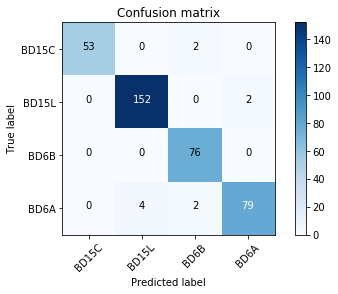

In [15]:
plot_confusion_matrix(conf_mat, classes=paths)